## KEY NOTE

This notbook is complete guide to end to end machine learning problem from scratch, I followed the book by Aurelien Geron, The steps described by him are really detailed, so I decided to replicate it on my own

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Notebook Navigation</h3>

[1. Project Skeleton](#1)   
[2. Load the Data](#2)  
[3. Training a Binary Classifier](#3)   
[4. Create a Test Set](#4)    
[5. Discover and Visualize Data to Gain Insights](#5)  
&nbsp;&nbsp;&nbsp;&nbsp;[a. Visualizing Geographical Data](#5a)   
&nbsp;&nbsp;&nbsp;&nbsp;[b. Looking for Correlations](#5b)       
&nbsp;&nbsp;&nbsp;&nbsp;[c. Experimenting with Feature Combinations](#5c)     
[6.Preparing Data for Machine Learning Algorithms](#6)     
&nbsp;&nbsp;&nbsp;&nbsp;[a. Data Cleaning](#6a)     
&nbsp;&nbsp;&nbsp;&nbsp;[b. Handling Text and Categorical Features](#6b)     
&nbsp;&nbsp;&nbsp;&nbsp;[c. Column Transformers](#6c)     
&nbsp;&nbsp;&nbsp;&nbsp;[d. Transformation Pipelines](#6d)     
[7. Select and Train a Model](#7)     
&nbsp;&nbsp;&nbsp;&nbsp;[a. Training and Evaluating on Training Set](#7a)     
&nbsp;&nbsp;&nbsp;&nbsp;[b. Better Evaluation Using Cross Validation](#7b)     
[8. Fine-Tune a Model](#8)  
&nbsp;&nbsp;&nbsp;&nbsp;[a. Grid Search](#8a)     
&nbsp;&nbsp;&nbsp;&nbsp;[b. Analyse the Best Models and Their Errors](#8b)       
[9. Evaluate Your System on Test Set](#9)     

<a id="1"></a>
## 1. Project Skeleton
Before starting out any project, we must first plan our steps and have clarity on what type of problem we are tackling and what tools can be used and what cannot be used and why not?. This "why not" question will help you gain more insights on your ML journey. The following are key points I took into consideration.

Staircase
* What kind of ML problem statement is it? Try to define it
* Understand the type of data?
* Keep a test data aside for EDA
* Relationships between various features, ie EDA 
* Try your intuition about the field: 
   * What can be important features that effect a house price? Bedrooms? Area? Population?
* Data preprocessing: Building a pipeline for it
* Applying models to predict
* What must be the evaluation metric?
* Evaluate the model on Test data

<a id="2"></a>
## 2. Load the Data

In [1]:
#Import the data
import numpy as np
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)

In [2]:
#this returns sorted dataset

def sort_mnist(mnist):
    reorder_train =np.array(sorted([(target,i) for i,target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
sort_mnist(mnist)

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
mnist.target.shape

(70000,)

In [6]:
X,y = mnist["data"],mnist["target"]

In [7]:
# plot some digit
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def show_digit(index):
    digit = X[index]
    image = digit.reshape(28,28)
    plt.imshow(image, cmap=matplotlib.cm.binary,interpolation="nearest")
    plt.axis("off")
    plt.show()
    print(y[index])

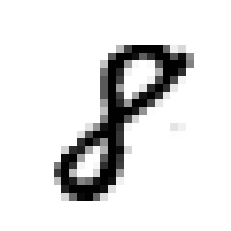

8


In [8]:
show_digit(52400)

In [9]:
#create test and train set
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [10]:
#shuffle the dataset
import numpy as np
shuffle_index=np.random.permutation(60000)
X_train,y_train=X_train[shuffle_index],y_train[shuffle_index]

<a id="3"></a>
## 3. Training a Binary Classifier

In [11]:
# training 8 and not 8 binaru classifier
y_train_8=(y_train==8)
y_test_8 =(y_test==8)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf= SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_8)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([X[52400]])

array([ True])

<a id="4"></a>
## 4. Performance Measures

<a id="4a"></a>
### a. Measuring Accuracy Using Cross-Validation

In [15]:
#implementing Cross Vlaidation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds= StratifiedKFold(n_splits=3,random_state=42)

for train_index,test_index in skfolds.split(X_train,y_train_8):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_8[train_index])
    X_test_fold =X_train[test_index]
    y_test_fold = y_train_8[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9264
0.9369
0.9227


In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_8,cv=3,scoring="accuracy")

array([0.9264, 0.9369, 0.9227])

<a id="4b"></a>
### b. Confusion Matrix

In [19]:
# use confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_8,cv=3)

In [22]:
y_train_pred

array([ True,  True, False, ..., False, False, False])

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_8,y_train_pred)

array([[52767,  1382],
       [ 2898,  2953]], dtype=int64)

<a id="4c"></a>
### c. Precision and Recall

In [26]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_8,y_train_pred)

0.681199538638985

In [27]:
recall_score(y_train_8,y_train_pred)

0.5047000512732867

In [29]:
#f1 score
from sklearn.metrics import f1_score
f1_score(y_train_8,y_train_pred)

0.5798154329471825

<a id="4d"></a>
### c. Precision/Recall Tradeoff

In [31]:
# let plot a precicion/Recall curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
y_scores=cross_val_predict(sgd_clf,X_train,y_train_8,cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_8,y_scores)

In [38]:
#function to plot
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])

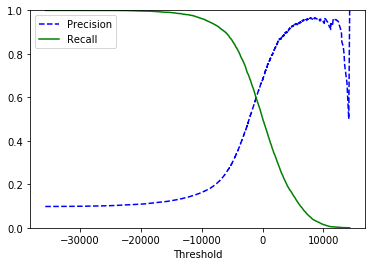

In [39]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

Text(0, 0.5, 'Precision')

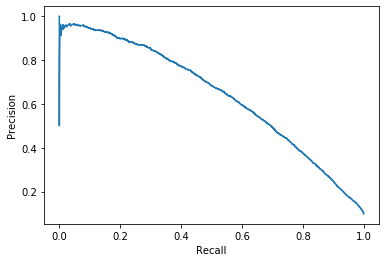

In [46]:
plt.plot(recalls,precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")